In [57]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [58]:
device = torch.device('cpu')
if (torch.cuda.is_available()):
    device = torch.device('cuda')

## HYPERPARAMS

In [3]:
dataroot = '../storage/data/AS_storage/'
workers = 4
batch_size = 32
image_size = 784
label_dim=10
nc = 1
nz = 100

num_epochs = 50
lr = 0.0002
momentum = 0.5
dampening = 0

k=1

## DATA

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_ds = torchvision.datasets.FashionMNIST(dataroot, train=True, download=True, transform=transforms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=workers)
print('Length of dataset:',len(train_ds))

Length of dataset: 60000


0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot

Images shape: torch.Size([32, 1, 28, 28])
Labels: tensor([6, 0, 5, 9, 5, 6, 2, 8, 4, 8, 0, 1, 4, 4, 6, 8, 1, 9, 5, 7, 5, 0, 9, 0,
        3, 2, 9, 0, 1, 5, 4, 0])


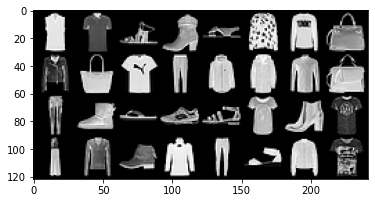

In [5]:
for images, labels in train_dl:
    print('Images shape:',images.shape)
    plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1,2,0))
    print('Labels:',labels)
    break

## MODELS

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.label_emb = nn.Embedding(10,10)
        
        self.fc1 = nn.Sequential(
            nn.Linear(nz+label_dim , 256),
            nn.LeakyReLU(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256 , 512),
            nn.LeakyReLU(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 1024),
            nn.LeakyReLU(0.2),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(1024 , 784),
            nn.Tanh()
        )
        
    def forward(self, images, labels):
        #RECIEVES BATCH OF SIZE (batch_size, nz)
        images = images.view(images.size(0), -1)
        labels = self.label_emb(labels)
        out = torch.cat((images, labels), dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_emb = nn.Embedding(10,10)

        
        self.fc1 = nn.Sequential(
            nn.Linear(784+label_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256 , 1),
            nn.Sigmoid()
        )
        
    def forward(self, images, labels):
        #RECIEVES BATCH OF SIZE (batch_size, 784) or (batch_size, 1, 28, 28)
        images = images.view(images.size(0), -1)
        labels = self.label_emb(labels)
        out = torch.cat((images, labels), dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

## LOSS FUNCTIONS

In [9]:
opt_g = torch.optim.Adam(generator.parameters(), lr)
opt_d = torch.optim.Adam(discriminator.parameters(), lr)

criterion = nn.BCELoss()

## PRE-TRAIN FUNCTIONS

In [10]:
real_labels = torch.ones(batch_size,1).to(device)
fake_labels = torch.zeros(batch_size,1).to(device)

In [11]:
fixed_noise = torch.randn(10, nz).to(device)
fixed_conditions = torch.LongTensor(np.arange(0,10)).to(device)

## PRE-TRAIN TEST

In [12]:
# sample = generator(fixed_noise, fixed_conditions).detach()
# print("Generated Samples:", sample.shape)

# sample_output = discriminator(sample, fixed_conditions).detach()
# print("Sample Outputs:", sample_output.shape)

## TRAIN

In [13]:
start_time = time.time()

loss_d = []
loss_g = []

for epoch in range(num_epochs):
    loss_d_ = 0.0
    loss_g_ = 0.0
    for i, (images, labels) in enumerate(train_dl):
        #DISCRIMINATOR
        opt_d.zero_grad()
        
        real_conditions = labels.to(device)        
        real_images = images.to(device)
        fake_conditions = torch.randint(0,10,(batch_size,)).to(device)
        fake_images = generator(torch.randn(batch_size, nz).to(device), fake_conditions).detach()
        
        real_outputs = discriminator(real_images, real_conditions) 
        fake_outputs = discriminator(fake_images, fake_conditions) 
        
        real_loss = criterion(real_outputs, real_labels)
        fake_loss = criterion(fake_outputs, fake_labels)
        real_loss.backward()
        fake_loss.backward()
        
        opt_d.step()
        
        loss_d_ += real_loss + fake_loss
        
        #GENERATOR
        opt_g.zero_grad()
        
        fake_conditions = torch.randint(0,10,(batch_size,)).to(device)
        output = discriminator(generator(torch.randn(batch_size, nz).to(device), fake_conditions), fake_conditions)
        
        loss = criterion(output, real_labels)
        loss.backward()
        
        opt_g.step()
        
        loss_g_ += loss
    
    epoch_loss_g = loss_g_/i
    epoch_loss_d = loss_d_/i
    loss_g.append(epoch_loss_g)
    loss_d.append(epoch_loss_d)
    print(f'{epoch}/{num_epochs} | Generator_Loss: {epoch_loss_g:.8f} | Discriminator_Loss: {epoch_loss_d:.8f} | Time: {time.time() - start_time:.0f} seconds')
    
    if epoch%10==0:
        sample = generator(fixed_noise, fixed_conditions).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=5, pad_value=1, normalize=False)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join('visuals', 'FashionMNIST_cGAN_{}.jpg'.format(str(epoch).zfill(3))))    
    
print(f'\nTOTAL DURATION: {time.time() - start_time:.0f} seconds')
sample = generator(fixed_noise, fixed_conditions).detach()
grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=5, pad_value=1, normalize=False)   
torchvision.utils.save_image(grid.detach().cpu(), os.path.join('visuals', 'FashionMNIST_cGAN_50.jpg'))    

0/50 | Generator_Loss: 1.55190969 | Discriminator_Loss: 1.08378148 | Time: 32 seconds
1/50 | Generator_Loss: 1.49323690 | Discriminator_Loss: 1.04251111 | Time: 65 seconds
2/50 | Generator_Loss: 1.12169898 | Discriminator_Loss: 1.13725841 | Time: 97 seconds
3/50 | Generator_Loss: 1.04888153 | Discriminator_Loss: 1.18376887 | Time: 129 seconds
4/50 | Generator_Loss: 1.09445965 | Discriminator_Loss: 1.17066956 | Time: 161 seconds
5/50 | Generator_Loss: 1.09742022 | Discriminator_Loss: 1.16182899 | Time: 193 seconds
6/50 | Generator_Loss: 1.07326376 | Discriminator_Loss: 1.19137192 | Time: 225 seconds
7/50 | Generator_Loss: 1.08383131 | Discriminator_Loss: 1.17225969 | Time: 258 seconds
8/50 | Generator_Loss: 1.12961471 | Discriminator_Loss: 1.15747344 | Time: 290 seconds
9/50 | Generator_Loss: 1.12597239 | Discriminator_Loss: 1.13897860 | Time: 323 seconds
10/50 | Generator_Loss: 1.13951921 | Discriminator_Loss: 1.11955321 | Time: 356 seconds
11/50 | Generator_Loss: 1.12749517 | Discrimi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


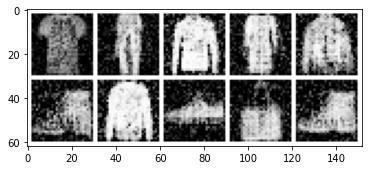

In [14]:
sample = generator(fixed_noise, fixed_conditions).detach()
grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=5, pad_value=1, normalize=False)   
plt.imshow(grid.detach().cpu().permute(1,2,0))    

## EVALUATION

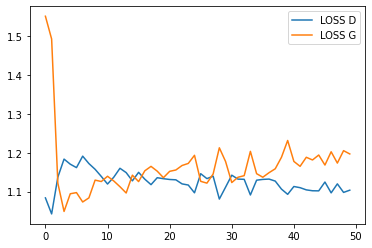

In [15]:
plt.figure()

plt.plot(loss_d, label='LOSS D')
plt.plot(loss_g, label='LOSS G')
plt.legend()
plt.show()

In [61]:
def generateItem(label):
    noise = torch.randn(1,nz)
    label = torch.LongTensor(label)
    img = generator(noise, label)
    plt.imshow(img.detach().cpu().permute(1,2,0))

In [62]:
generateItem(1)

RuntimeError: Input, output and indices must be on the current device

## SAVING

In [63]:
torch.save(generator.state_dict(), './fashion_mnist_cgan_generator.pt')
torch.save(discriminator.state_dict(), './fashion_mnist_cgan_discriminator.pt')

RuntimeError: cuda runtime error (710) : device-side assert triggered at /pytorch/torch/csrc/generic/serialization.cpp:31